In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
'''
Dataset: Maternal Health Risk Data Set
Features:
1. Body Temp
2. Heart Rate
3. Blood Sugar (from Regression)
4. Age

Target: Risk Level (Low, Medium, High)
1014 samples
'''

df = pd.read_csv('Data/Maternal Health Risk Data Set.csv')
df = df.drop(['SystolicBP', 'DiastolicBP'], axis=1)
# df = df.drop(['SystolicBP', 'DiastolicBP', 'BS'], axis=1)
df.head()

,Age,BS,BodyTemp,HeartRate,RiskLevel
0,25,15.0,98.0,86,high risk
1,35,13.0,98.0,70,high risk
2,29,8.0,100.0,80,high risk
3,30,7.0,98.0,70,high risk
4,35,6.1,98.0,76,low risk


# EDA

<Figure size 1200x800 with 0 Axes>

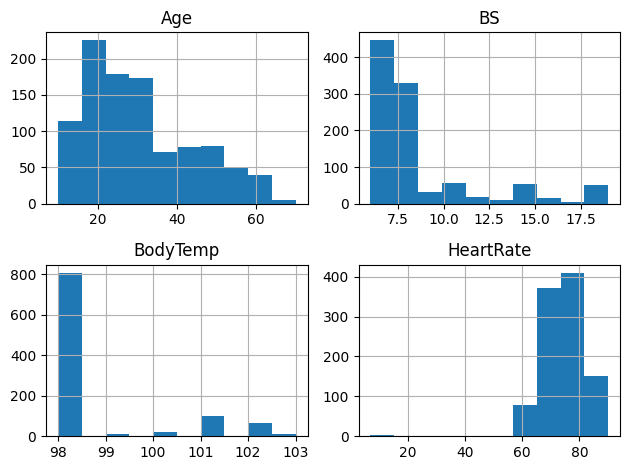

In [7]:
# Histograms
plt.figure(figsize=(12, 8))
df.hist()
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

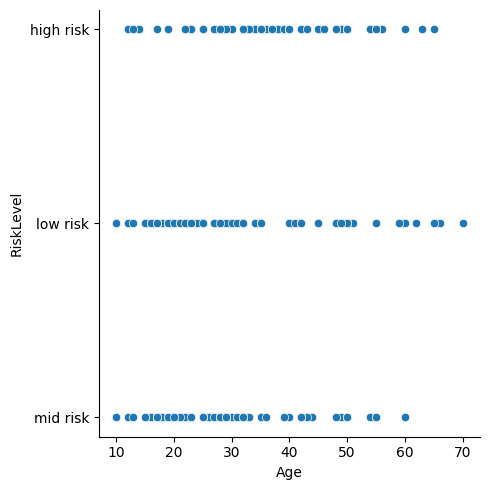

In [8]:
# Bivariate Analysis with the target
target = 'RiskLevel'
# Age vs risk
plt.figure(figsize=(12, 8))
sns.relplot(x='Age', y='RiskLevel', data=df)
plt.show()

<Figure size 1200x800 with 0 Axes>

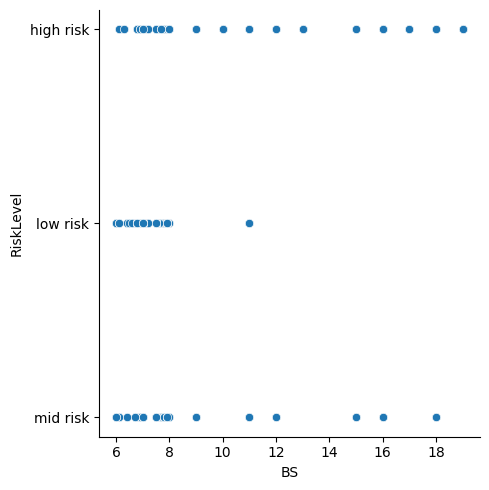

In [9]:
# Blood Sugar vs risk
plt.figure(figsize=(12, 8))
sns.relplot(x='BS', y='RiskLevel', data=df)
plt.show()

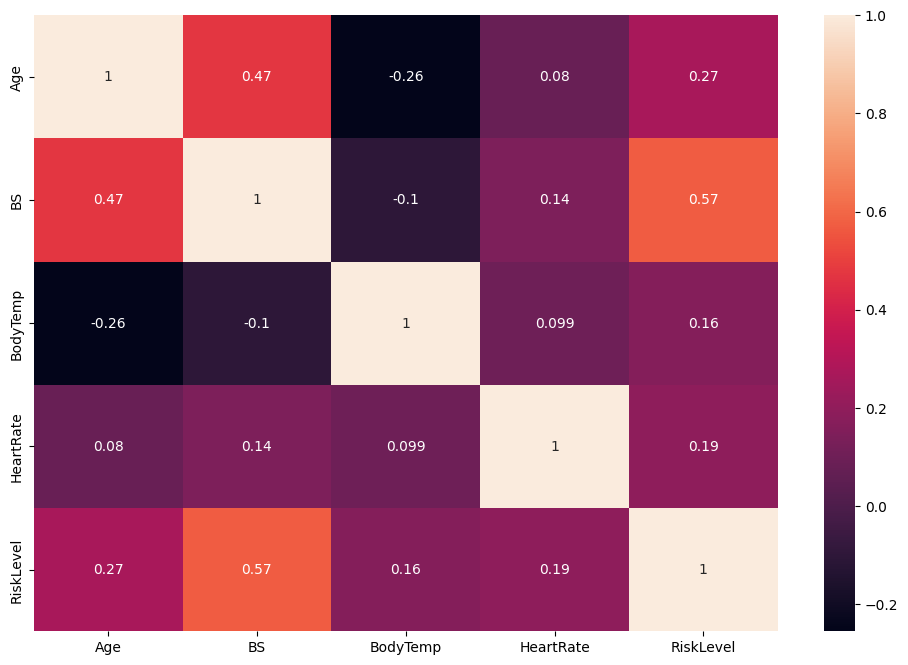

In [9]:
# Correlation Matrix
# Encoding target variable
df['RiskLevel'] = df['RiskLevel'].map({'low risk': 0, 'mid risk': 1, 'high risk': 2})

plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [10]:
print(df['RiskLevel'].value_counts())
# Imbalanced dataset will need to be balanced using SMOTE algorithm

RiskLevel
0    406
1    336
2    272
Name: count, dtype: int64


# Preprocessing

In [11]:
X = df.drop('RiskLevel', axis=1).to_numpy()
y = df['RiskLevel']

# Model

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [13]:
def cross_validate(model, X, y):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    pipeline = Pipeline(steps=[('s', StandardScaler()), ('o', SMOTE()), ('m', model)])
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)
    return scores

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('MLP', MLPClassifier()))

results = []
names = []

for name, model in models:
    scores = cross_validate(model, X, y)
    results.append(scores)
    names.append(name)
    print(f'{name}: {scores.mean()} +- ({scores.std()})')

LR: 0.5867531580744282 +- (0.021639420219564946)
KNN: 0.686406867287714 +- (0.04423261129894026)
SVC: 0.6351216895088524 +- (0.03891250980013287)
DT: 0.7879920011705603 +- (0.016210882291140438)
RF: 0.8126371750475541 +- (0.012652412474485472)
XGB: 0.8234697361361751 +- (0.009576612233332752)
MLP: 0.6124469589816125 +- (0.04906053091465918)


In [19]:
# Fine tuning XGB model using GridSearchCV
from sklearn.model_selection import GridSearchCV

model = XGBClassifier()
pipeline = Pipeline(steps=[('s', StandardScaler()), ('o', SMOTE()), ('classifier', model)])
param_grid = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__max_depth': [3, 4, 5, 8, 10],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__subsample': [0.5, 0.75, 1],
    'classifier__colsample_bytree': [0.5, 0.75, 1],
    'classifier__reg_alpha': [0, 0.5, 1],
    'classifier__reg_lambda': [0, 0.5, 1],
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

grid_search = GridSearchCV(pipeline, param_grid, scoring='accuracy', n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}')

Best: 0.8293908208554847 using {'classifier__colsample_bytree': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 500, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.5}


In [28]:
best_params = grid_result.best_params_
print(best_params)

{'classifier__colsample_bytree': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 500, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.5}


In [34]:
# Save best params to a file
import json
with open('best_params.json', 'w') as f:
    json.dump(best_params, f)

{'classifier__colsample_bytree': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 500, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.5}

In [31]:
best_model_params = {
    'n_estimators': best_params['classifier__n_estimators'],
    'max_depth': best_params['classifier__max_depth'],
    'learning_rate': best_params['classifier__learning_rate'],
    'subsample': best_params['classifier__subsample'],
    'reg_alpha': best_params['classifier__reg_alpha'],
    'reg_lambda': best_params['classifier__reg_lambda'],
}

# Exporting Best Models

In [ ]:
import pickle

In [23]:
# Export RF model to Pickle to be implemented in Flask app
rf = RandomForestClassifier()
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('o', SMOTE()), ('model', rf)])
pipeline.fit(X, y)

with open('rf_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [33]:
# Export XGB model to Pickle to be implemented in Flask app
xgb = XGBClassifier(**best_model_params)
pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('o', SMOTE()), ('model', xgb)])
pipeline.fit(X, y)

with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(pipeline, file)